Video explicativo [https://youtu.be/oiY6rfsGA3c?si=PEcG7XzVTjp6keRe]

Tutorial explicado [https://pennylane.ai/qml/demos/tutorial_qpe/]

# Tema 3: Estimación Cuántica de Fase

Curso IAC02.

Autor: Alejandro Mata Ali

En este notebook vamos a implementar la estimación cuántica de fase para diferentes operadores y estados.

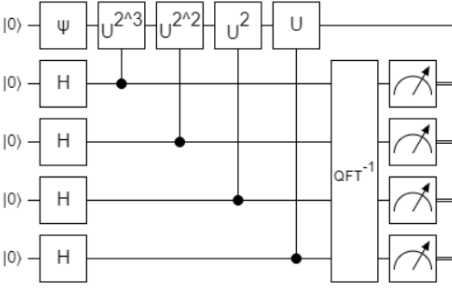

## Librerías

In [ ]:
%%capture
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
import numpy as np

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener n qubits para el estado y m qubits clock para los autovalores (que definirán el tamaño de la QFT inversa). También tendremos como entrada el operador unitario. La salida será la puerta de la QPE.

Para ahorrar tiempo, utilizaremos la QFT que tiene qiskit implementada.

Vamos a eliminar los SWAP de la QFT, por lo que cambiamos el orden de los qubits clock.

In [ ]:
from qiskit.circuit.library import QFT

In [ ]:
def QPE(n:int,m:int,unitary):
    #Registros
    qr = QuantumRegister(n, 'State')
    clock = QuantumRegister(m, 'Clock')

    #Circuito
    qc = QuantumCircuit(clock, qr, name='QPE')

    #Capa de h
    qc.h(clock)

    #Para cada qubit clock
    for i in range(m):
        qc.append(unitary.repeat(2**(i)).control(1), [clock[i]]+qr[:])


    #QFT inversa final sin los SWAPS
    qc.append(QFT(m, do_swaps=False).inverse(), clock[::-1])

    #Tenemos que descomponer la IQFT para evitar errores
    qc_desc = qc.decompose('IQFT', reps=1)

    #Convertimos en gate
    QPE_Gate = qc_desc.to_gate()

    return QPE_Gate

Creamos una unitaria de prueba. Por simplicidad, vamos a escoger $\mathbb{I}\otimes P(2\pi\theta) \otimes P(2\pi\theta) \otimes \mathbb{I}$

In [ ]:
n = 4
theta = 0.25
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

Veamos el circuito obtenido.

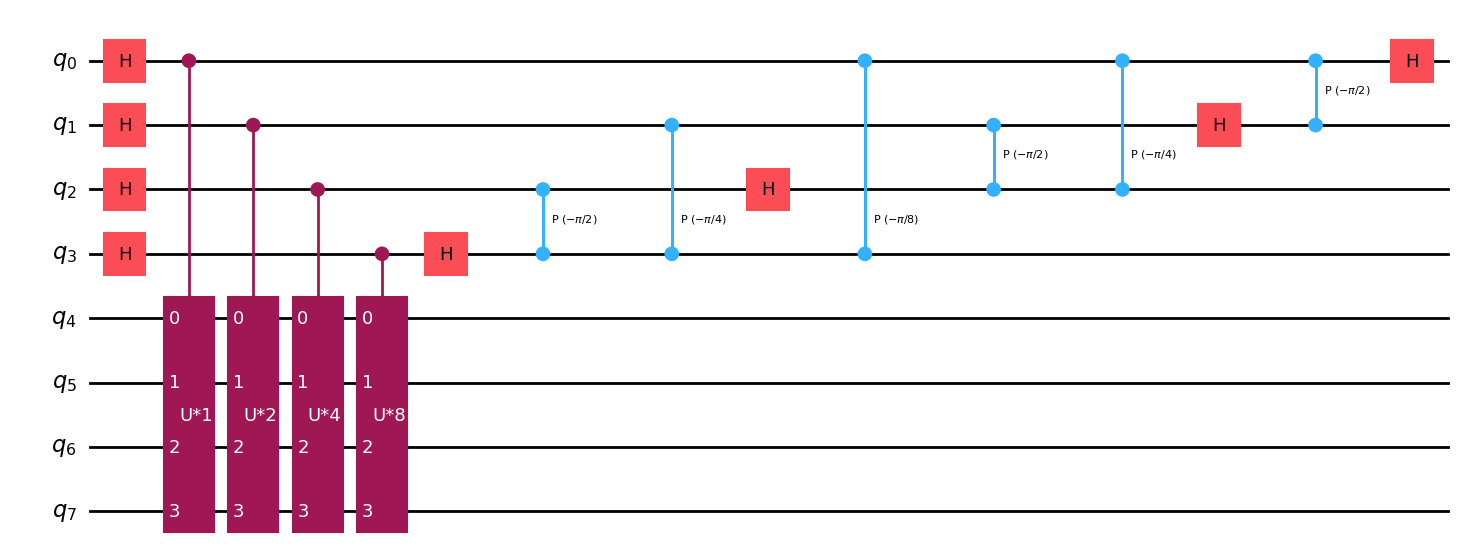

In [ ]:
m = 4
qc = QuantumCircuit(n+m)
#Llamamos directamente a la puerta, sin necesidad de guardarla
qc.append(QPE(n,m,unitary), range(n+m))

#Descomponemos para ver el circuito
qc2 = qc.decompose(['QPE', 'IQFT'], reps=2)
qc2.draw('mpl')

Vamos a aplicarla sobre un estado concreto. Este será un estado de la base computacional, ya que estos son los autovectores de las P. En principio, si el qubit 1 o el 2 están en $|1\rangle$, el autovalor será $e^{i2\pi\theta}$, pero si están en $|0\rangle$ ambos será $1$, y si están en $|1\rangle$ ambos, será $e^{i2\pi 2\theta}$.

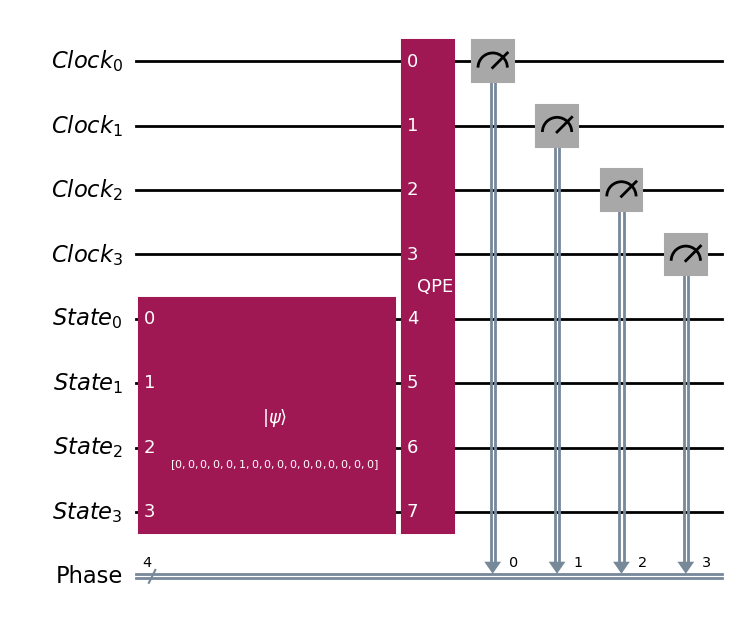

In [ ]:
#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1 (Recuerda el orden de los qubits)
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

#Circuito cuantico
qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)

#Aplicamos la QPE
qc.append(QPE(n,m, unitary), clock[:]+qr[:])

#Medimos los qubits clock a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)

qc.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

/usr/local/lib/python3.10/dist-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


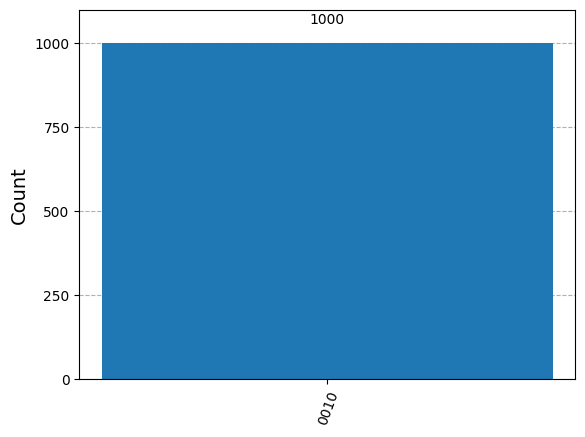

In [ ]:
#Número de shots
n_shots = 1000

#Simulador de n+m qubits
backend = GenericBackendV2(num_qubits=n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Comprobamos qué valor de $\theta$ hemos obtenido.

In [ ]:
resultado = '0010'

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)

theta =  0.25 . theta obtenido =  0.25


---
# Otras pruebas

Vamos a probar con otros estados.

/usr/local/lib/python3.10/dist-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


theta =  0.25 . theta obtenido =  0.25


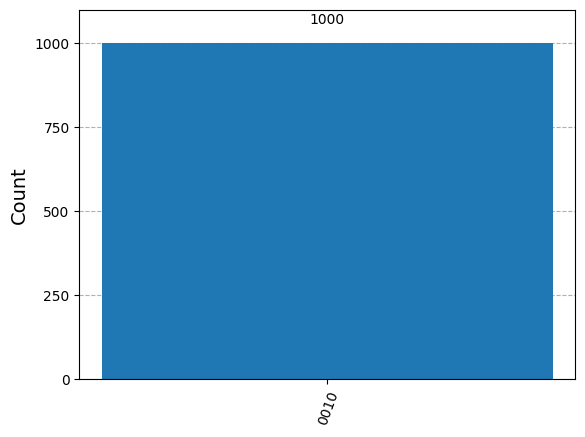

In [ ]:
n = 4
theta = 0.25
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = GenericBackendV2(num_qubits=n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)


/usr/local/lib/python3.10/dist-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


theta =  0.25 . theta obtenido =  0.5


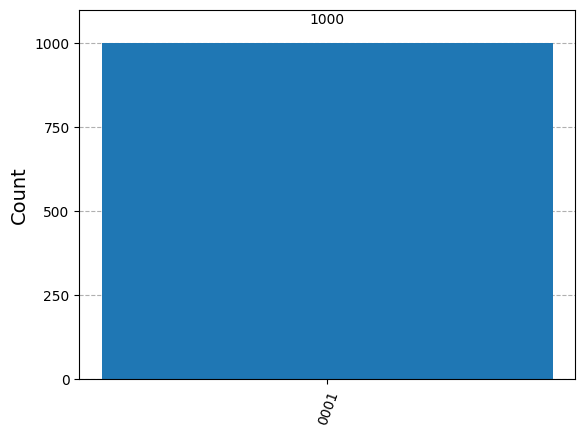

In [ ]:
n = 4
theta = 0.25
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0110'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = GenericBackendV2(num_qubits=n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)


---
# $\theta$ no fracción de 2

Probemos con un theta que no sea una fracción de 2.

/usr/local/lib/python3.10/dist-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


theta =  0.3 . theta obtenido =  0.3125


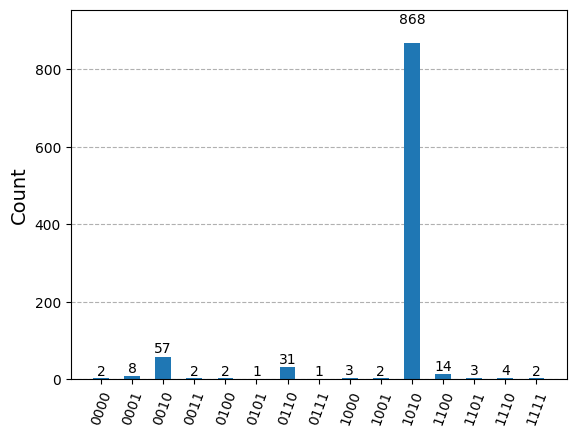

In [ ]:
n = 4
theta = 0.3
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = GenericBackendV2(num_qubits=n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)


Vemos que ahora hay una distribución en vez de un único pico. El máximo de la distribución coincide con el valor más próximo al valor de $\theta$. ¿Qué pasaría si aumentamos el número de qubits clock?

/usr/local/lib/python3.10/dist-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


theta =  0.3 . theta obtenido =  0.296875


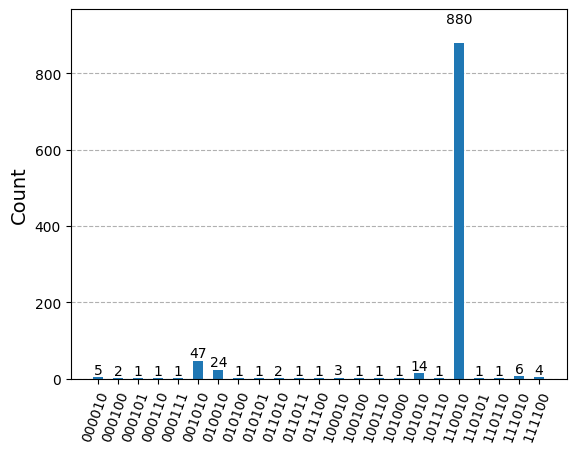

In [ ]:
n = 4
theta = 0.3
m = 6
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = GenericBackendV2(num_qubits=n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos que el pico obtenido es más alto y el valor que representa es más cercano a $\theta$, por lo que al aumentar el número de qubits clock, aumentamos la precisión para obtener el autovalor.

---
# Ejercicio

El estado $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ es autovector del operador X, con autovalor 1. Haz que el operador sea HXP($2\pi\theta$)XH de un cierto ángulo  y observa el autovalor obtenido.

/usr/local/lib/python3.10/dist-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


theta =  0.125 . theta obtenido =  0.125


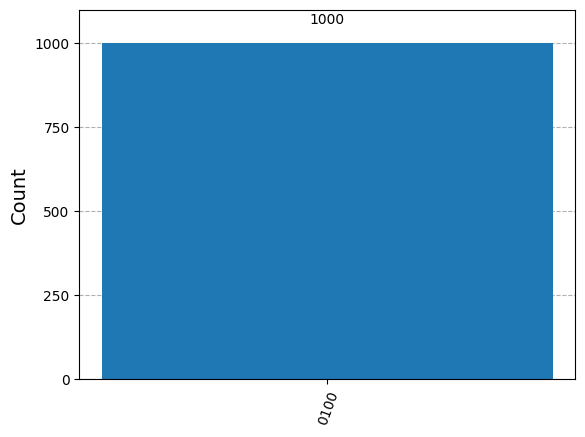

In [ ]:
n = 1
theta = 0.125
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.h(0)
unitary_circuit.x(0)
unitary_circuit.p(2*np.pi*theta,0)
unitary_circuit.x(0)
unitary_circuit.h(0)
unitary = unitary_circuit.to_gate()

#Empezamos en 1 todo
state = np.ones(2**n)

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(QPE(n,m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = GenericBackendV2(num_qubits=n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)

---
# Función de Qiskit

En Qiskit ya existe una función que realiza esta puerta. Esta es PhaseEstimation. Esta función permite indicarle:

1. Número de qubits clock: num_evaluation_qubits
2. Unitaria: unitary
3. Si queremos usar otra QFT inversa: iqft=None
4. Un nombre: name='QPE'

In [ ]:
from qiskit.circuit.library import PhaseEstimation

/usr/local/lib/python3.10/dist-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


theta =  0.25 . theta obtenido =  0.25


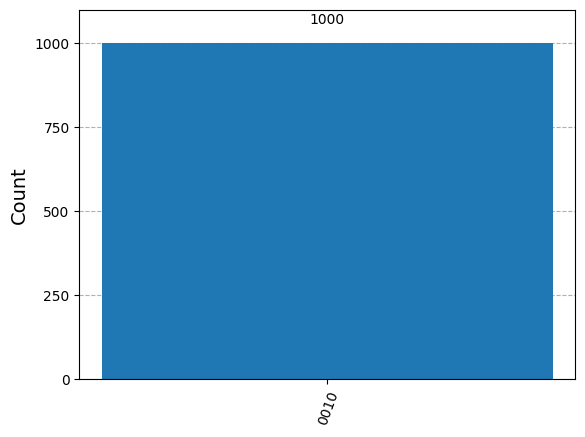

In [ ]:
n = 4
theta = 0.25
m = 4
unitary_circuit = QuantumCircuit(n, name='U')
unitary_circuit.p(2*np.pi*theta,[1,2])
unitary = unitary_circuit.to_gate()

#Empezamos en 0 todo
state = np.zeros(2**n)
#Añadimos el elemento en 1
elem = '0101'
#Convertimos a decimal
state[int('0b'+elem,2)] = 1

qr = QuantumRegister(n, name='State')
clock = QuantumRegister(m, name='Clock')

cr = ClassicalRegister(m, name='Phase')
qc = QuantumCircuit(clock, qr, cr, name='Circuit')
#Inicializamos el estado
qc.initialize(state, qr, normalize=True)
qc.append(PhaseEstimation(m,unitary),clock[:]+qr[:])

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure(clock, cr)
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = GenericBackendV2(num_qubits=n+m)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)
resultado = max(counts, key=counts.get)

#Hay que darle la vuelta
print('theta = ', theta, '. theta obtenido = ', int(resultado[::-1],2)/2**m)
#Ploteamos los histogramas de resultados
plot_histogram(counts)